# Laser Shooting

**Problem**
- We can calculate position of target relative to camera.
- How should we move laser from our target position.

In [1]:
%matplotlib widget
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def circle_intersec(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d = math.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

    # non intersecting
    if d > r0 + r1:
        return None
    # One circle within other
    if d < abs(r0 - r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a = (r0**2 - r1**2 + d**2) / (2 * d)
        h = math.sqrt(r0**2 - a**2)
        x2 = x0 + a * (x1 - x0) / d
        y2 = y0 + a * (y1 - y0) / d
        x3 = x2 + h * (y1 - y0) / d
        y3 = y2 - h * (x1 - x0) / d

        x4 = x2 - h * (y1 - y0) / d
        y4 = y2 + h * (x1 - x0) / d

        return (x3, y3, x4, y4)

In [3]:
def distance(x0, y0, x1, y1):
    return math.sqrt(pow(x1 - x0, 2) + pow(y1 - y0, 2))

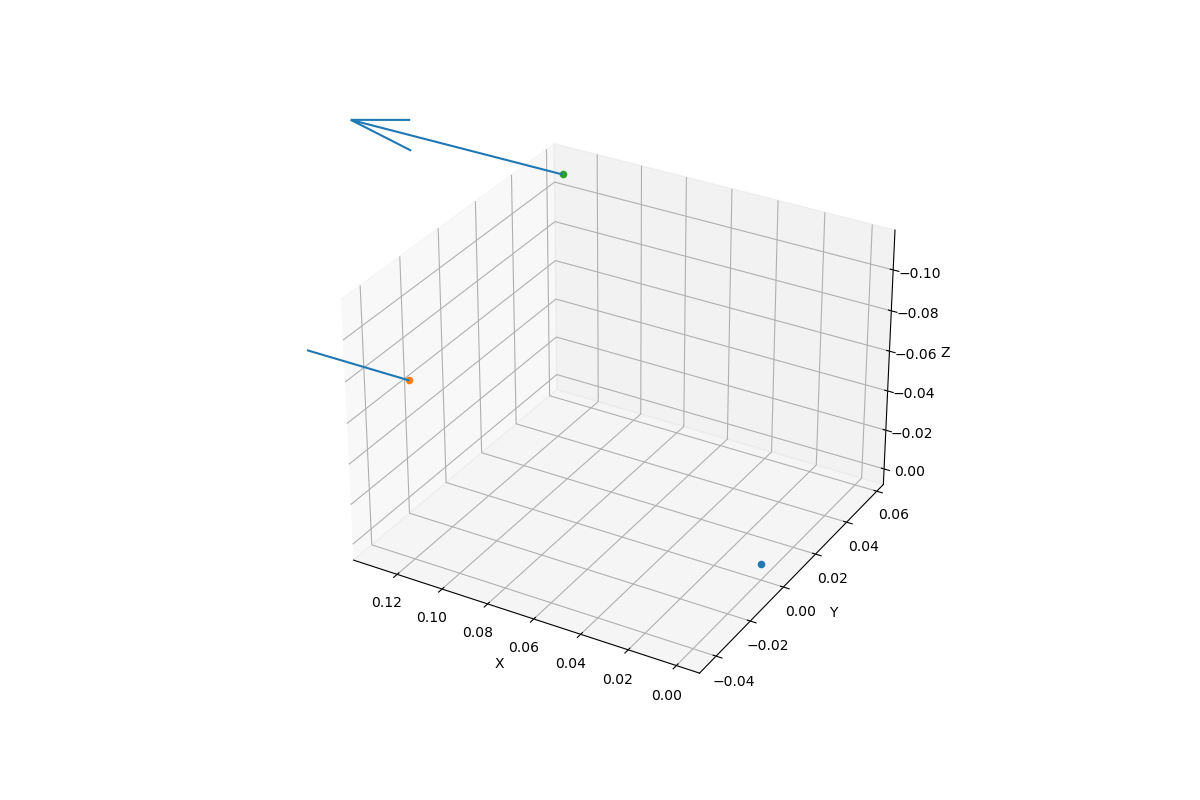

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.invert_zaxis()
ax.invert_xaxis()
ax.invert_yaxis()

# center point
ax.scatter3D(0, 0, 0)

# Nav cam
# ax.plot([0, 0.1177], [0, -0.0422], [0, -0.0826])
ax.scatter3D(0.1177, -0.0422, -0.0826)
ax.quiver(0.1177, -0.0422, -0.0826, 1, 0, 0, length=0.1)

# laser
ax.scatter3D(0.1302, 0.0572, -0.1111)
ax.quiver(0.1302, 0.0572, -0.1111, 1, 0, 0, length=0.1)

# ax.scatter3D(0.5771599999999992, -0.0044005491850808015, 0.024569734389619735)

## Calculate target position

In [5]:
# CONSTANT
cam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258],
        [0.000000, 534.765913, 500.335102],
        [0.000000, 0.000000, 1.000000],
    ]
)
dist_coeffs = np.array([-0.164787, 0.020375, -0.001572, -0.000369, 0.000000])
newcam_mat, _ = cv2.getOptimalNewCameraMatrix(
    cam_mat, dist_coeffs, (1280, 960), 1, (1280, 960)
)
newcam_mat
# np.linalg.inv(newcam_mat)

array([[347.69958496,   0.        , 633.39499987],
       [  0.        , 357.13922119, 494.69674079],
       [  0.        ,   0.        ,   1.        ]])

#### 1. Find target position on image 
From this https://stackoverflow.com/questions/30919957/undistort-vs-undistortpoints-for-feature-matching-of-calibrated-images \
We should use `undistort` more than `undistortPoint`

undistorting cropped image
https://stackoverflow.com/questions/68634072/opencv-undistort-cropped-image


array([172, 104,  45], dtype=uint16)

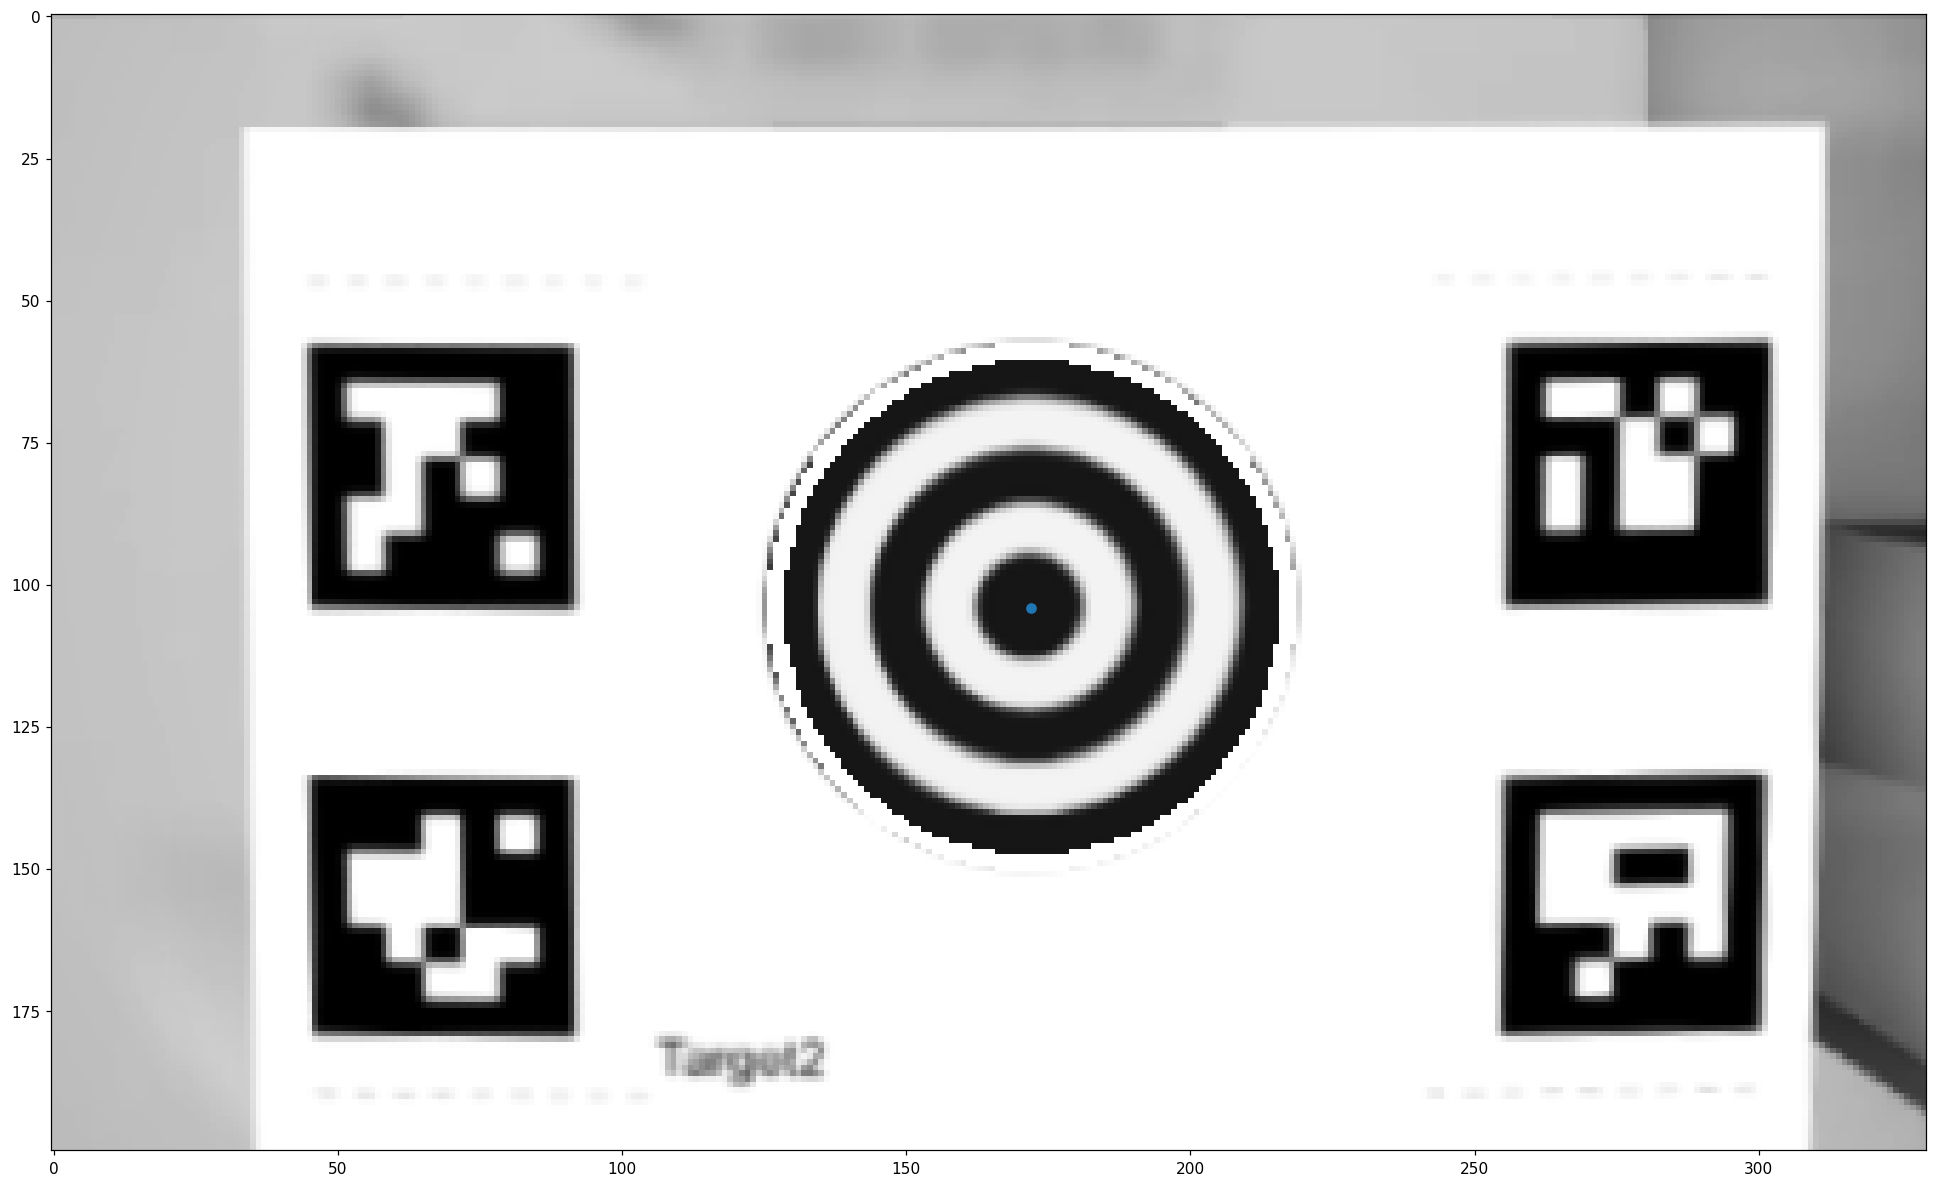

In [6]:
# do the way in java
%matplotlib inline
# cam_mat for cropped img
tcam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258 - 500],
        [0.000000, 534.765913, 500.335102 - 500],
        [0.000000, 0.000000, 1.000000],
    ]
)

img = cv2.imread("../Img/target2.png", cv2.IMREAD_GRAYSCALE)
c_img = img[500:700, 500:830].copy()
ud_img = cv2.undistort(c_img, tcam_mat, dist_coeffs)

circles = cv2.HoughCircles(
    ud_img, cv2.HOUGH_GRADIENT, 1, 300, param1=50, param2=30, minRadius=40, maxRadius=50
)
circles = np.uint16(np.around(circles))
center = circles[0][0]

fig = plt.figure(figsize=(22, 22), dpi=110)
plt.scatter(center[0], center[1])
cv2.circle(ud_img, (center[0], center[1]), center[2], (255, 255, 255), 2)
plt.imshow(ud_img, cmap="gray")

center

In [7]:
center[0] += 500
center[1] += 500
center

array([672, 604,  45], dtype=uint16)

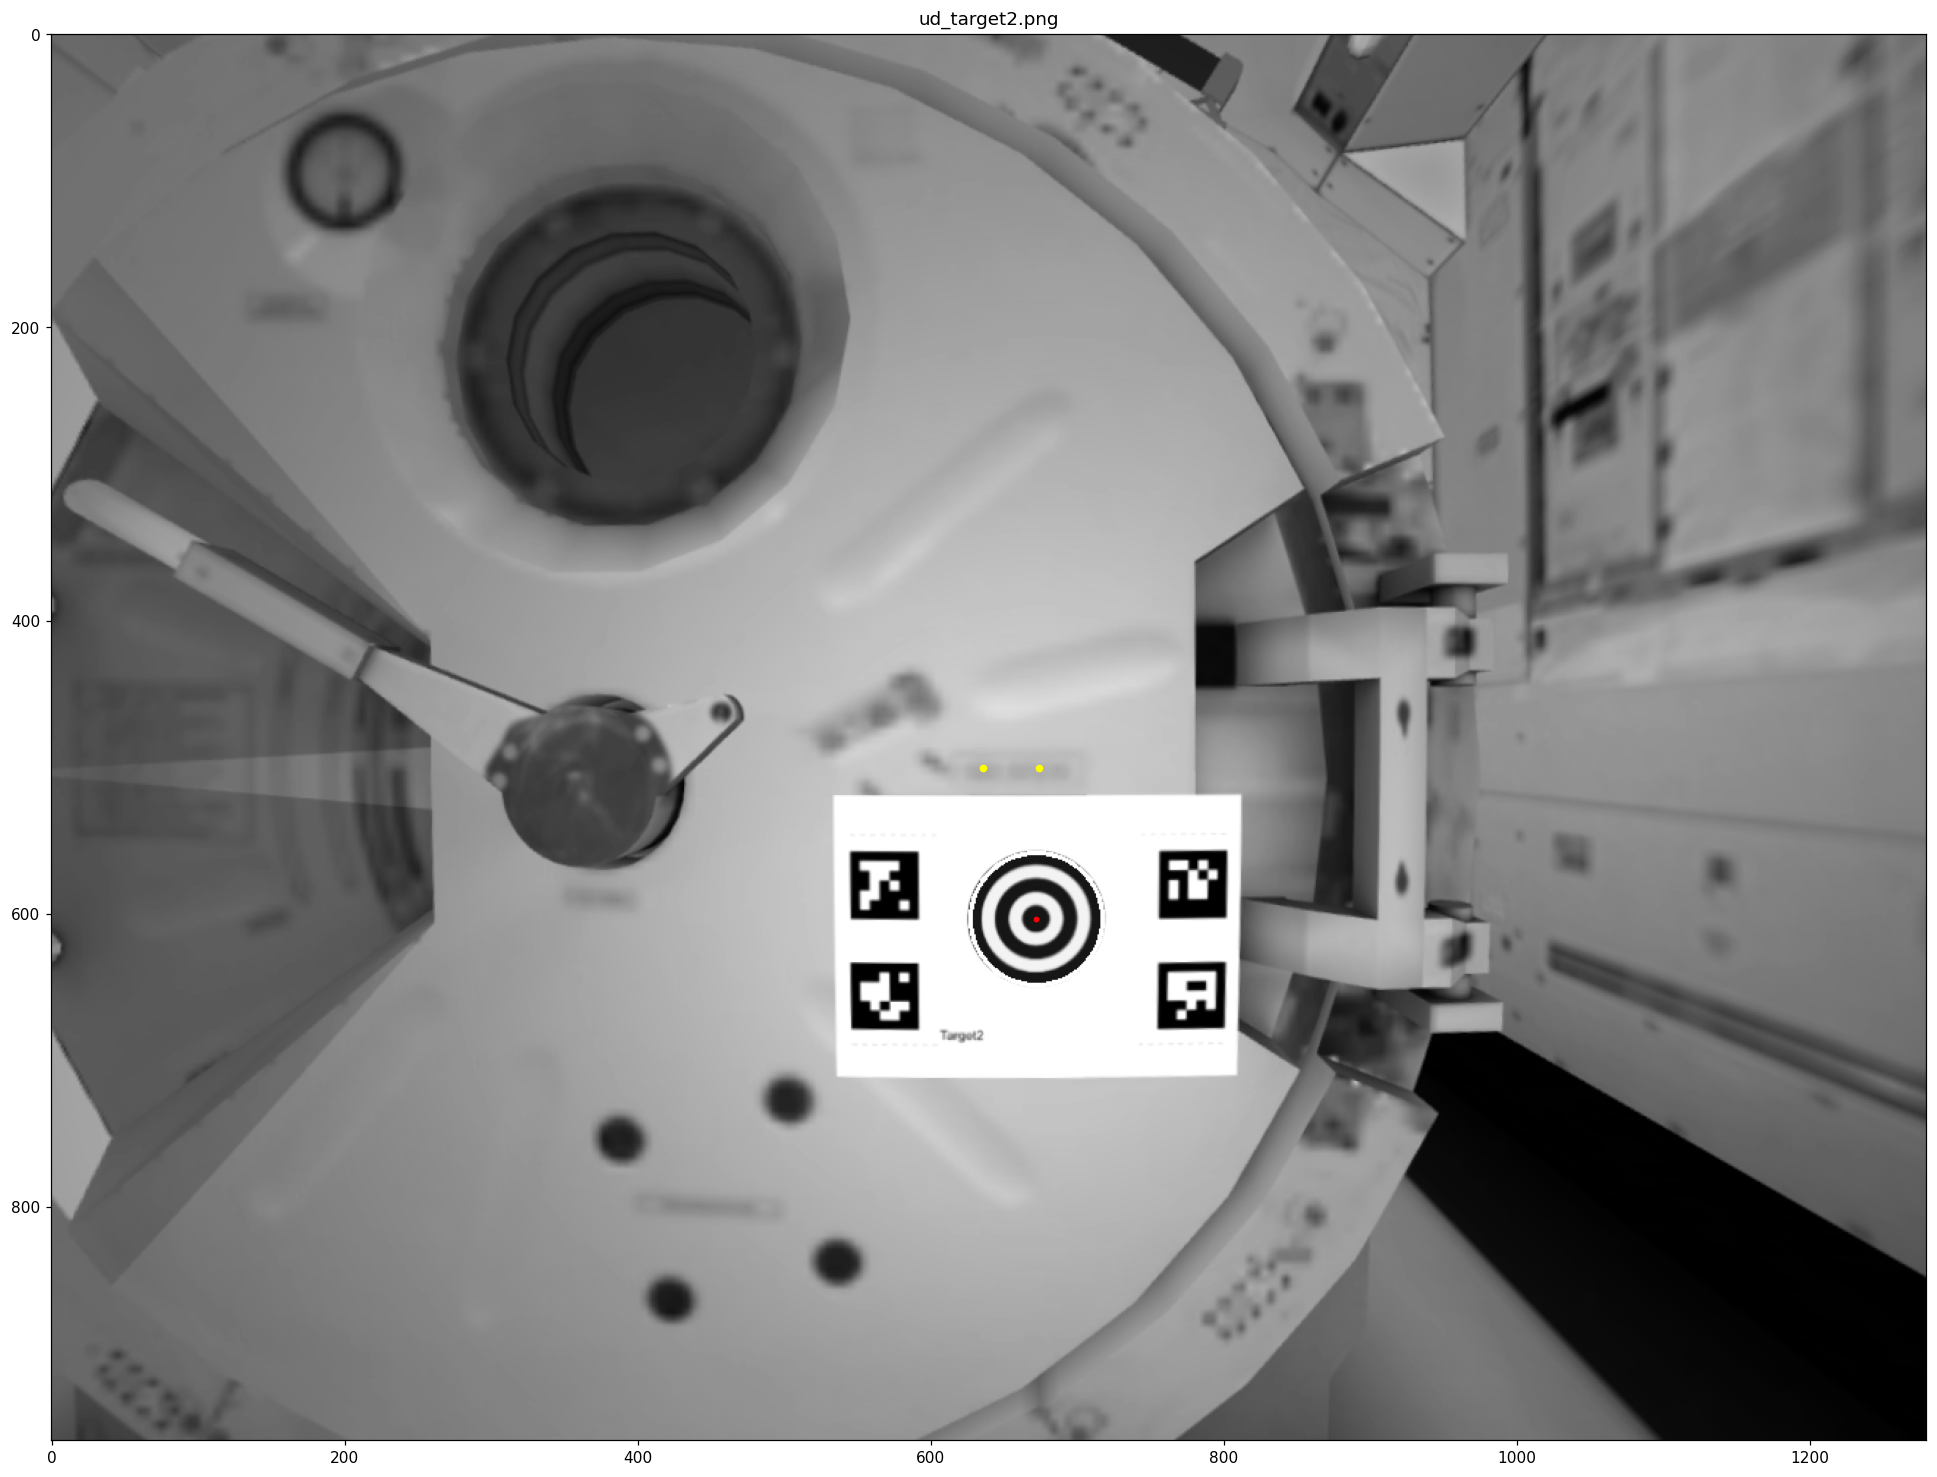

In [8]:
out = cv2.undistort(img, cam_mat, dist_coeffs)

fig = plt.figure(figsize=(22, 22), dpi=110)
ax = fig.add_subplot()
ax.set_title("ud_target2.png")

cv2.circle(out, (center[0], center[1]), center[2], (255, 255, 255), 2)
ax.scatter(center[0], center[1], c="red", s=8)
# ax.scatter(640, 480, c="yellow", s=16)
ax.scatter(635.434258, 500.335102, c="yellow", s=16)
ax.scatter(635.434258 + 38.199231982621875, 500.335102, c="yellow", s=16)
# ax.scatter(677.5, 603.5, c="red", s=8)

ax.imshow(out, cmap="gray")

#### 2. Calculate world position

In [9]:
# center = np.array([665.6041259765625, 562.1497802734375])
center

array([672, 604,  45], dtype=uint16)

#### Use pinhole camera model to compute position in camera cordinate
From [OpenCv Doc](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#)

Distance from point 2 to target is 

$s = |Z_t - (-Z_{p2}-Z_{nav})|$ \
$s = \text{Distance to target} = 0.45946$ \
$A = \text{Camera Matrix}$

$$\begin{bmatrix}
X_c \\ Y_c \\ Z_c
\end{bmatrix}
=A^{-1}s\begin{bmatrix}
u \\ v \\ 1
\end{bmatrix}$$

In [10]:
s = abs(-10.581 - (-9.922840 - 0.1177))
uv = np.array([[center[0]], [center[1]], [1]])
# uv = np.dot(s, uv)
A_inv = np.linalg.inv(cam_mat)
cam_c = np.matmul(A_inv, uv)
s, cam_c

(0.5404599999999995,
 array([[0.06990124],
        [0.19385098],
        [1.        ]]))

In [11]:
# camera cordinate with offset to world
cam_c[0][0] - 0.0422, cam_c[1][0] - 0.0826, s

(0.027701242721954525, 0.11125098316840554, 0.5404599999999995)

#### Use meter/pixel approximation
AR tag in realworld is 0.05 m width and height so we use this information to calculate $C$ (meter/pixel constant) \
$C$ (meter/pixel) $= \frac{0.05}{\text{s_len}}$

In [12]:
# reading ar tag
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
corners, ids, _ = cv2.aruco.detectMarkers(out, aruco_dict)

In [13]:
s_len = 0
for i in range(len(corners)):
    c = corners[i][0]
    s1 = distance(c[0][0], c[0][1], c[1][0], c[1][1])
    s2 = distance(c[1][0], c[1][1], c[2][0], c[2][1])
    s3 = distance(c[2][0], c[2][1], c[3][0], c[3][1])
    s4 = distance(c[3][0], c[3][1], c[0][0], c[0][1])
    s_avg = sum([s1, s2, s3, s4]) / 4
    s_len += s_avg

s_len /= 4
s_len

45.25975353391218

In [14]:
meter_px = 0.05 / s_len
meter_px

0.001104734252751422

Calculating world cordinate by using difference from camera center

In [15]:
cx, cy = 635.434258, 500.335102  # this is from camera matrix
xdist = center[0] - cx
ydist = center[1] - cy
xdist, ydist

(36.565742, 103.664898)

In [16]:
# convert to meter
xdist *= meter_px
ydist *= meter_px
# target distance
target_dist = abs(
    -10.581 - (-9.922840 - 0.1177)
)  # target_y - (astrobee_pos + navcam_offset)
target_dist

xdist, target_dist, ydist

(0.04039542766467129, 0.5404599999999995, 0.11452216362858238)

## Calculating angle to turn

In [17]:
xc = xdist - 0.0422  # subtract nav cam offset
yc = -ydist + 0.0826  # subtract nav cam offset
"""
xc, yc = cam_c[0][0] - 0.0422, cam_c[1][0] - 0.0826
"""
xc, yc

(-0.0018045723353287135, -0.03192216362858237)

### Circle method 
Based on https://youtu.be/_eJM4LArG18 \
Simple visualization https://www.desmos.com/calculator/xx9zlhkxfs

##### YZ Plane

Compute $\text{r1}$, $\text{r2}$, $l$

In [18]:
# target distance
t_l = abs(-10.5 - (-9.92284))
# xc = cam_c[1][0] - 0.0826

In [19]:
pivot_angle = math.radians(math.degrees(math.atan(0.1302 / 0.1111)) + 90)
pivot_angle, math.degrees(pivot_angle)

(2.4351843752901243, 139.5257870403261)

In [20]:
r1 = math.sqrt(0.1302**2 + 0.1111**2)
l = math.sqrt(t_l**2 + yc**2)
r2 = r1 * math.cos(pivot_angle) + math.sqrt(
    l**2 - (r1**2) * pow(math.sin(pivot_angle), 2)
)
l, r1, r2

(0.5780421179557154, 0.1711585522257068, 0.4370649117746743)

In [21]:
intersec = circle_intersec(
    0,
    0,
    r1,
    t_l,
    yc,
    r2,
)
print(t_l, yc, r2)
intersec

0.5771599999999992 -0.03192216362858237 0.4370649117746743


(0.14425931843941744,
 -0.09211134047116426,
 0.15353751029837417,
 0.07564048473784818)

Compute angle using biggest x on intersection points

In [22]:
# triangle base
tri_base = distance(0.1302, 0.1111, intersec[2], intersec[3])
angle = 2 * math.asin((tri_base / 2) / r1)
f"∠x : {angle}, {math.degrees(angle)}°"

'∠x : 0.24865673215156228, 14.246981299799481°'

##### XY Plane

Compute $\text{r1}$, $\text{r2}$, $l$

In [23]:
t_l = abs(-10.5 - (-9.92284))
# yc = cam_c[0][0] - 0.0422

In [24]:
pivot_angle = math.atan(0.1302 / 0.0572) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.727652176143348, 156.28295767268844)

In [25]:
r1 = math.sqrt(0.1302**2 + 0.0572**2)
# cam_c[0][0] - 0.0422 is a difference between camera and pivot
l = math.sqrt(t_l**2 + xc**2)
r2 = r1 * math.cos(pivot_angle) + math.sqrt(
    l**2 - (r1**2) * pow(math.sin(pivot_angle), 2)
)
l, r1, r2

(0.5771628211183674, 0.14221068876846074, 0.4441214100843816)

In [26]:
intersec = circle_intersec(0, 0, r1, xc, t_l, r2)
print(xc, t_l, r2)
intersec

-0.0018045723353287135 0.5771599999999992 0.4441214100843816


(0.043591844670877664,
 0.13536480738430534,
 -0.04443745852108111,
 0.13508957132283456)

Compute angle using biggest x on intersection points

In [27]:
tri_base = distance(0.0572, 0.1302, intersec[0], intersec[1])
angle = 2 * math.asin((tri_base / 2) / r1)
f"∠y : {angle}, {math.degrees(angle)}°",

('∠y : 0.10239506915387264, 5.866805305467103°',)

### Simple Trigonometry
We need to change reference frame from camera to laser in implementation by some way

In [28]:
x_angle = math.atan(xdist / target_dist)
y_angle = math.atan(ydist / target_dist)
print(f"∠x : {x_angle} , {math.degrees(x_angle)}°")
print(f"∠y : {y_angle} , {math.degrees(y_angle)}°")

∠x : 0.07460395998506153 , 4.2744920421069015°
∠y : 0.2088089257714643 , 11.963870171365391°


### Better circle method
We are getting rid of circle kekw.

##### YZ plane

In [29]:
pivot_angle = math.atan(0.1302 / 0.1111) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.435184375290124, 139.52578704032607)

In [30]:
t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)
# t_l = (0.1*523.105750)/95 + 0.1177
d = math.sqrt(0.1302**2 + 0.1111**2)
l = math.sqrt(t_l**2 + yc**2)
l_p = math.sqrt((t_l - 0.1302) ** 2 + (yc - 0.1111) ** 2)
t_l, l, d, l_p

(0.6581599999999987, 0.6589336917556488, 0.1711585522257068, 0.546989123190763)

In [31]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.7548724314894402, 0.536993295722918, 0.21787913576652218)

In [32]:
turn_angle = angle1 - angle2
print(f"∠x : {turn_angle} , {math.degrees(turn_angle)}°")

∠x : 0.21787913576652218 , 12.483554923379584°


In [33]:
t_l, yc

(0.6581599999999987, -0.03192216362858237)

##### XY plane

In [34]:
pivot_angle = math.atan(0.1302 / 0.0572) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.727652176143348, 156.28295767268844)

In [35]:
t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)
# t_l = (0.1*523.105750)/95 + 0.1177
d = math.sqrt(0.0572**2 + 0.1302**2)
l = math.sqrt((xc) ** 2 + t_l**2)
l_p = math.sqrt((xc - 0.0572) ** 2 + (t_l - 0.1302) ** 2)
t_l, l, d, l_p

(0.6581599999999987,
 0.6581624739236595,
 0.14221068876846074,
 0.531246930491343)

In [36]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.4166823150137028, 0.32692206719802197, 0.08976024781568082)

In [37]:
turn_angle = angle1 - angle2
print(f"∠y : {turn_angle} , {math.degrees(turn_angle)}°")

∠y : 0.08976024781568082 , 5.142883367886877°


In [38]:
xc, t_l

(-0.0018045723353287135, 0.6581599999999987)

In [40]:
for i in range(0, 5):
    x = xc - (i * 0.001)
    t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)
    d = math.sqrt(0.0572**2 + 0.1302**2)
    l = math.sqrt((x) ** 2 + t_l**2)
    l_p = math.sqrt((x - 0.0572) ** 2 + (t_l - 0.1302) ** 2)
    angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
    angle2 = (
        math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)
    )
    turn_angle = angle1 - angle2
    print(f"∠y : {turn_angle} , {math.degrees(turn_angle)}°")

∠y : 0.08976024781568082 , 5.142883367886877°
∠y : 0.09127915215817828 , 5.229910176196075°
∠y : 0.09279783544919568 , 5.31692431918841°
∠y : 0.09431629068854591 , 5.403925395782706°
∠y : 0.09583451088098344 , 5.490913005180916°


In [41]:
0.09279783544919568 - 0.08976024781568082

0.00303758763351486

### Another method

##### YZ plane

In [ ]:
t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)
t_l, yc

In [ ]:
V = [1, 0]
Q = [t_l, yc]
D = [0.1302, 0.1111]

In [ ]:
A = -V[1] * Q[0] + V[0] * Q[1]
B = -V[1] * Q[1] - V[0] * Q[0]
C = -V[1] * D[0] + V[0] * D[1]
A, B, C

In [ ]:
phi1 = math.acos(A / math.sqrt(A**2 + B**2))
phi2 = math.asin(C / math.sqrt(A**2 + B**2))
phi1, -phi1, phi2, -phi2

In [ ]:
angle = phi1 - math.acos(C / math.sqrt(A**2 + B**2))
angle

## Other Things

In [ ]:
def rotateV(x, y, angle):
    x1 = x * math.cos(angle) - y * math.sin(angle)
    y1 = x * math.sin(angle) + y * math.cos(angle)
    return x1, y1


rotateV(1, 0, math.radians(360) - turn_angle)